# QUIDDIT
## Quantification of Infrared-active Defects in Diamond and Inferred Temperatures

### 2) QUIDDIT Main

### 2.1)  Imports and Data
Let's start by importing a few important functions and reading the measured spectrum. We also generate two empty structured arrays for the results. Structured arrays are implemented in numpy and allow the user to create their own data type, here: results_dtype and review_dtype ([click here for more information](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.rec.html)). It makes writing results to a file easier and also allows for specific results to be called using a keyword, e.g. results['T'] to extract all temperature data, as we will see later.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
import scipy.optimize as op
from scipy import integrate
from scipy import stats

import QUIDDIT_settings as sett
import QUIDDIT_utility as ut

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [65]:
#results = np.zeros(1, dtype=ut.results_dtype)
#review = np.zeros(1, dtype=ut.review_dtype)

In [66]:
spectrum = np.loadtxt('C:/FTIR/aafakedata corrected/cLS Arg 81 HQ linescan 40 300025.CSV', delimiter=',')

### 2.2)  Fitting the 3107 cm$^{-1}$ peak (N$_3$VH)

First, a pseudo-Voigt function is fitted to the commonly occuring peak at 3107 cm$^{-1}$ which is caused by the N$_3$VH defect. Fitting this peak first means that its height can be used to predict the height of the 1405 cm$^{-1}$ peak which is due to the same defect, thus constraining the fitting parameters used (see section 2.3 Fitting the platelet peak).

Despite our best efforts in baseline removal (see the Ipython Notebooke on Baseline "Correction and Normalisation"), a small residual baseline can remain in the region above 3000 cm$^{-1}$. Hence, the first step in fitting the 3107 cm$^{-1}$ peak is fully removing this residual baseline.

In [67]:
# extract area around 3107 cm-1 H peak
H_area = ut.spectrum_slice(spectrum, 3000, 3200)
H_bg_left = ut.spectrum_slice(spectrum, 3000, 3050)
H_bg_right = ut.spectrum_slice(spectrum, 3150, 3200)
H_bg_both = np.vstack((H_bg_left, H_bg_right))

* np.polyfit(x, y, order) fits a polynomial funtction of a given order (3 in this case) to x-y-data and returns the fitted parameters (H_p_bg)
* In our case, the polynomial function looks like this:
$y = a\cdot x^3 + b\cdot x^2 + c\cdot x + d$
* so H_p_bg will contain a, b and c
* np.polyval((a, b, c, d), x) evaluates a polynomial function with our best fit parameters

In [68]:
H_p_bg = np.polyfit(H_bg_both[:,0], H_bg_both[:,1], 3)
H_bg = np.polyval(H_p_bg, H_area[:,0])

print('Results of fitting the baseline in this region:\n {}'.format(H_p_bg))

Results of fitting the baseline in this region:
 [ -1.05430652e-08   9.82303734e-05  -3.04830392e-01   3.14833997e+02]


In [69]:
# subtract the polynomial (H_bg) from the measured spectrum (H_area):
H_absorp_new = H_area[:,1] - H_bg
H_wav_new = H_area[:,0]
spec_new = np.column_stack((H_wav_new, H_absorp_new))
    
H_bg_a, H_bg_b, H_bg_c, H_bg_d = H_p_bg

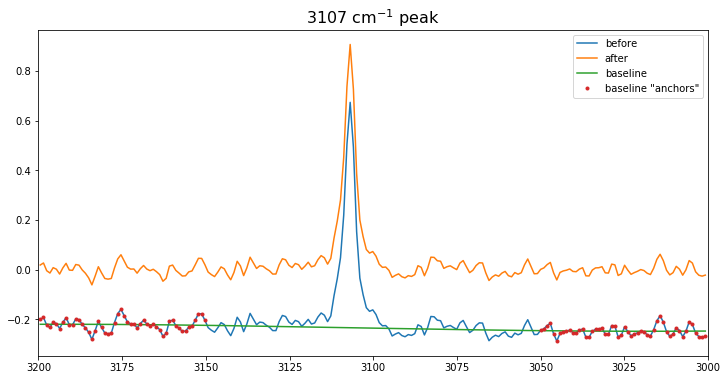

In [70]:
plt.figure()
plt.plot(H_area[:,0], H_area[:,1], '-', label='before')
plt.plot(spec_new[:,0], spec_new[:,1], '-', label='after')
plt.plot(H_area[:,0], H_bg,'-', label='baseline')
plt.plot(H_bg_both[:,0], H_bg_both[:,1], '.', label='baseline "anchors"')
plt.title('3107 $\mathregular{cm^{-1}}$ peak', fontsize=16)
plt.xlim(3000,3200)
plt.gca().invert_xaxis()
plt.legend(loc='best')

As can be seen, the baseline is now completely flat and the noise now fluctuates around 0. Let's start fitting the peak.

For simplicity, the same function is used to fit peaks in QUIDDIT in several places. "pseudovoigt" provides (yes, you guessed it!) a pseudo-Voigt function that is determined by the peak's position (x0), height (I), half widths (left and right; HWHM_l and HWHM_r) and sigma, the Lorentzian contribution to the peak. A pseudo-Voigt function is a linear combination of a Gaussian and a Lorentzian (Cauchy) distribution. The 3107 cm$^{-1}$ peak is expected to be Lorentzian, so the sigma parameter should be close to 1.

In [71]:
# interpolate the area around 3107 cm-1 (spec_new) at new wavenumber values (wav_inter)     
wav_inter = wav_inter = np.arange(H_wav_new[0], H_wav_new[-1], 0.1)
peak_inter = ut.inter(spec_new, wav_inter)

the scipy.optimize (here: op) function finds the minimum of a function (in this case ut.pseudovoigt) with certain starting conditions (H_x0) and boundary conditions (H_bounds). A range of least-square methods can be used (for more information see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)).

The function returns the parameters of the best fit (H_res) along with some information on the number of function evaluations, success of the fitting and others.

In [72]:
# define starting conditions and boundaries for peak position, peak height, full widths left and right and sigma
H_x0 = (3107, 0, 1, 1, 0.5)
H_bounds = [(3106,3108),(0,None),(0.001,5),(0.001,5),(0,1)]  #(min, max)-pairs


H_res = op.minimize(ut.pseudovoigt, 
                    method='SLSQP', 
                    args=(wav_inter, peak_inter), 
                    x0=H_x0, bounds=H_bounds)

print('Results of the 3107 cm-1 peak fit: \n{}'.format(H_res))

H_fit = ut.pseudovoigt_fit(H_wav_new, *H_res.x)

Results of the 3107 cm-1 peak fit: 
     fun: 0.8511275885155598
     jac: array([ 0.00114545, -0.00030632, -0.0009962 ,  0.00133702,  0.00028698])
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([  3.10681585e+03,   8.85499096e-01,   1.65000459e+00,
         2.05033222e+00,   8.02645792e-01])


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


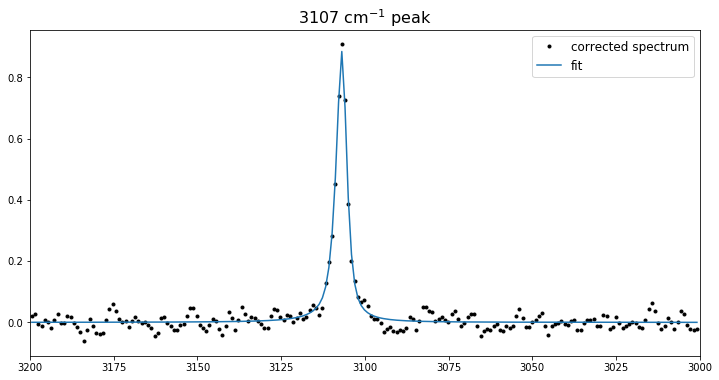

In [73]:
plt.figure()
plt.plot(spec_new[:,0], spec_new[:,1], 'k.', label='corrected spectrum')
plt.plot(H_wav_new, H_fit, '-', label='fit')
plt.title('3107 $\mathregular{cm^{-1}}$ peak', fontsize=16)
plt.xlim(3000,3200)
plt.gca().invert_xaxis()
plt.legend(loc='best', fontsize=12)

### 2.3)  Fitting the platelet peak

Now, as promised, we are going to fit the platelet peak. The platelet peak is a little more difficult for several reasons:
* it can be asymmetric
* it is surrounded by other peaks:
 * the edge of the B-centre spectrum (ca. 1332$^{-1}$)
 * the 1405 cm$^{-1}$ peak (due to N$_3$VH)
* its position can vary (between 1358 and 1378 $^{-1}$ according to the literature

This is what the "ultimatepsv" function was designed for. It is uses the "pseudovoigt" function three to fit the platelet peak, the 1332 $^{-1}$ and the 1405 N$_3$VH peak simultaneously. If this is done correctly (and the first baseline correction has fully removed the low wavenumber "tail" of the diamond absorption), we won't need another baseline correction this time. To be on the safe side we allow a constant value to be added.

Just like before, let's start by extracting and interpolating the relevant spectral region.

In [74]:
pp = ut.spectrum_slice(spectrum, 1327, 1420)

pp_wav_inter = np.arange(pp[0][0], pp[-1][0], 0.01)
pp_inter = ut.inter(pp, pp_wav_inter)

First, we need to do some calculations to define boundary conditions (lb and ub for lower and upper boundary) for the platelet peak fit.
* The height of the 1405 cm$^{-1}$ peak (I1405) is related to that of the 3107 cm$^{-1}$ peak (H_res.x[1] - H_res.x are the best fit parameters from fitting the 3107 cm$^{-1}$ peak). We are adding and subtracting 10% to allow for a small error
* the height of the 1332 cm$^{-1}$ peak will be similar to the measured absorption value at this wavenumber
* the position of the peak maximum will be near the maximum measured absorption (p_max) value in this spectral area (pp2)
* the constant (residual baseline) value can be bracketed between 0 and the absorption value found at 1420 cm$^{-1}$.

Further constraints are as follows:
* a half width of >50 is unlikely to represent a real platelet peak
* the 3107 cm$^{-1}$ is generally quite narrow, so half widths of <5 are assumed
* for all three peaks $0 < \sigma < 1$ (the Lorentzian contribution)


In [75]:
# constraining the height of thr 1405cm-1 peak:
I1405 = 0.257 * H_res.x[1]      #from empirical analysis on platelet degraded spectra 
H_lb = I1405 - .1*I1405
H_ub = I1405 + .1*I1405

# constraining the height of the 1332 cm-1 peak:
I1332 = ut.height(1332,pp)
if I1332 <= 0:
    B_lb = 0
    B_ub = .5
else:
    B_lb = I1332 - .1*I1332
    B_ub = I1332 + .1*I1332
    
# constraining the position of the maximum of the platelet peak
pp2 = ut.spectrum_slice(spectrum, 1350, 1380)
p_max = pp2[np.argmax(pp2[:,1])][0]
p_lb = p_max - 1.5
p_ub = p_max + 1.5

#constraining the constant value added to the fit
cc = min(pp[:,1])
if cc>=0:
    c_ub = cc
    c_lb = 0
else:
    c_ub = 0
    c_lb = cc

# first guess (psv_x0) and boundary conditions (p_bounds):
psv_x0 = (p_max, 0, 5, 5, 1, 1405, 
          I1405, 5, 5, 1, 1332, 
          I1332, 5, 5, 0, 0)

p_bounds = [(p_lb,p_ub),(0,None),(.01,50),(.01,50),(0,1),
            (1404.5,1405.5),(H_lb,H_ub),(.1,5),(.1,5),(0,1),
            (1331,1333),(B_lb,B_ub),(.1,5),(.1,5),(0,1), (c_lb,c_ub)]

cons = ({'type': 'ineq', 'fun': ut.pp_cons1}, 
        {'type': 'ineq', 'fun': ut.pp_cons2}, 
        {'type': 'ineq', 'fun': ut.pp_cons3})

In [76]:
pp_res = op.minimize(ut.ultimatepsv, x0=psv_x0, args=(pp_wav_inter, pp_inter), 
                     method='SLSQP', 
                     bounds=p_bounds, constraints=cons)

pp_fit = ut.ultimatepsv_fit(pp_wav_inter, *pp_res.x)

print('Results of the platelet peak fit: \n{}'.format(pp_res))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Results of the platelet peak fit: 
     fun: 6.119272296716658
     jac: array([  5.66244125e-05,  -1.52963400e-03,  -2.49445438e-04,
        -1.91688538e-04,  -3.26470786e+00,   4.19139862e-04,
        -4.11521941e+00,   4.50849533e-04,  -1.62124634e-04,
        -3.91304493e-04,   5.50662363e+00,  -4.26610231e-01,
        -3.27223527e+00,  -1.37096030e+00,  -2.72410512e-02,
        -3.85867608e+01])
 message: 'Optimization terminated successfully.'
    nfev: 428
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([  1.35967165e+03,   4.25263212e-01,   9.08550891e+00,
         1.30637154e+01,   1.00000000e+00,   1.40527982e+03,
         2.50330594e-01,   1.44499055e+00,   1.42052552e+00,
         5.00914839e-01,   1.33100000e+03,   2.00463466e+00,
         5.00000000e+00,   5.00000000e+00,   6.15153496e-01,
         5.29723613e-01])


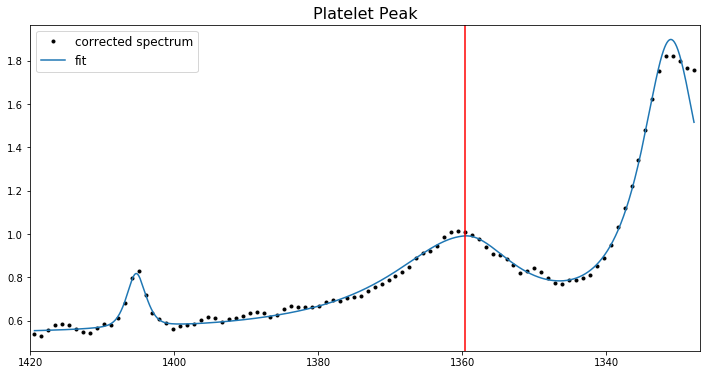

In [77]:
plt.figure()
plt.plot(pp[:,0], pp[:,1], 'k.', label='corrected spectrum')
plt.plot(pp_wav_inter, pp_fit, '-', label='fit')
plt.title('Platelet Peak', fontsize=16)
plt.xlim(1327,1420)
plt.axvline(x=pp_res.x[0], color='r')
plt.gca().invert_xaxis()
plt.legend(loc='best', fontsize=12)

The figure above shows the end result of the platelet region fit. The red arrow shows the maximum of the platelet peak. The peak area can be calculated directly from its height, width and $\sigma$:

In [78]:
platelet_peak_area = ut.peak_area(*pp_res.x[1:5])

print('platelet peak area: {}'.format(platelet_peak_area))

platelet peak area: 14.795723699335287


### 2.4) Fitting the nitrogen region

Lastly, the nitrogen region is fitted. The following cell opens the standard spectra of the C, A, X, B and D components:

In [79]:
C = np.column_stack((sett.std[:,0], sett.std[:,1]))
A = np.column_stack((sett.std[:,0], sett.std[:,2]))    #generate C, A, X, B and D std
X = np.column_stack((sett.std[:,0], sett.std[:,3]))    #spectra from CAXBD file
B = np.column_stack((sett.std[:,0], sett.std[:,4]))   
D = np.column_stack((sett.std[:,0], sett.std[:,5]))

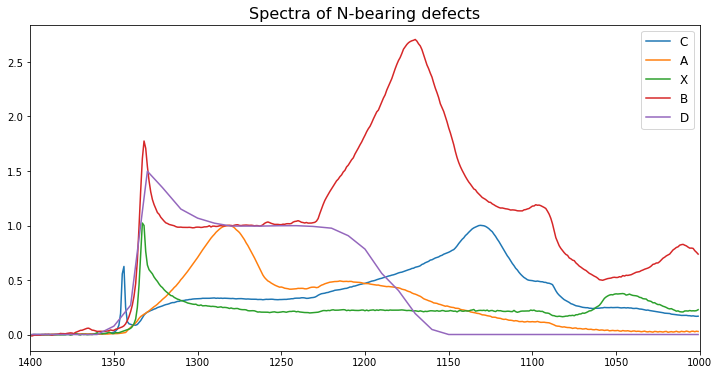

In [80]:
plt.figure()
plt.plot(C[:,0],C[:,1], '-', label='C')
plt.plot(A[:,0],A[:,1], '-', label='A')
plt.plot(X[:,0],X[:,1], '-', label='X')
plt.plot(B[:,0],B[:,1], '-', label='B')
plt.plot(D[:,0],D[:,1], '-', label='D')
plt.legend(loc='best', fontsize=12)
plt.title('Spectra of N-bearing defects', fontsize=16)
plt.xlim(1000,1400)
plt.gca().invert_xaxis()

In natural diamonds, the most commonly found components are A, B and D. In the QUIDDIT GUI, these are the components used by default but others can be used by changing the settings. Fitting will be achieved with a least squares routine and using a linear combination of these end-members of the form:

$a\cdot A + b\cdot B + d\cdot D + const. = fit$

The constant can be omitted by changing the settings in the QUIDDIT GUI. Let's start the fitting process by extracting and interpolating the spectral area of interest.

You can play around with which components are fitted by changing the following line of code. 

In [81]:
N_selection = np.array((0, 1, 0, 1, 1, 1))

selection = [comp for (comp,boolean) in zip(('C', 'A', 'X', 'B', 'D', 'constant'), N_selection) if boolean ==1]
print('You have selected {}'.format(selection))

You have selected ['A', 'B', 'D', 'constant']


The 0 and 1 in this array describe which components out of (C, A, X, B, D, constant) to use (=1) and which to omit (=0). Thus the default, (0, 1, 0, 1, 1, 1) means fit A, B, D and constant and omit A and X.

In [82]:
N_area = ut.spectrum_slice(spectrum, 1001, 1399)
N_wav_new = N_area[:,:-1]  

# interpolate C, A, X, B and D spectra:
C_new = ut.inter(C, N_wav_new)   
A_new = ut.inter(A, N_wav_new)
X_new = ut.inter(X, N_wav_new)                     
B_new = ut.inter(B, N_wav_new)
D_new = ut.inter(D, N_wav_new)

# interpolate measured spectrum (N part):
N_area_new = ut.inter(N_area, N_wav_new)
N_area_new = N_area_new.flatten()

In a similar manner to the platelet peak, we can constrain some of the parameters involved in fitting:
* the D-component is thought to be related to the platelet peak, so it can only be present if the platelet peak area is above a certain threshold value
* if D is present, its maximum value is constrained by the amount of B-centres present (assuming that platelets and B-centres are genetically related, thus the amount of B can be used to predict the amount of platelets present if the diamond is regular)
* The constant will be bracketed between 0 and the absorption value found at 1400

In [83]:
min_area = 5
    
if platelet_peak_area < min_area:
    print('No platelets here! :-(')    
    N_x0_d = 0.0
else:
    print('Yes, platelets are present! :-)')
    N_x0_d = None        

    
if N_selection[-1] == 1:
    polyx0 = N_area[-1,1]    
    if polyx0 >0:        
        polybounds = (0., polyx0)    
    else:
        polybounds = (polyx0, 0.)
else:
    polyx0 = 0
    polybounds = (0.,0.)

Yes, platelets are present! :-)


In [84]:
if N_selection[-2]==1:
    N_cons = ({'type': 'ineq', 'fun': ut.Nd_bound})
else:
    N_cons = None

N_x0 = [i for i,j in zip((.5, .5, .1, .5, 0., -polyx0), N_selection) if j==1]
N_bounds =  [i for i,j in zip([(0.,None),(0.,None),(0.,None),(0.,None),(0., N_x0_d), polybounds], N_selection) if j==1]

N_args = np.column_stack((C_new, A_new, X_new, B_new, D_new))[:,np.where(N_selection[:-1]==1)[0]]

In [85]:
N_res = op.minimize(ut.CAXBD_err, x0=N_x0, args=(N_args, N_area_new), 
                    method='SLSQP', 
                    bounds=N_bounds, constraints=N_cons)

N_fit = ut.CAXBD(N_res.x, N_args)

print('Results of nitrogen fitting:\n{}'.format(N_res))

factors: [ 0.5         0.5         0.         -0.58112982]
components: [[  2.97350993e-02   7.52449636e-01   0.00000000e+00]
 [  2.61754409e-02   7.66937703e-01   0.00000000e+00]
 [  2.92479936e-02   7.86054978e-01   0.00000000e+00]
 ..., 
 [ -1.29567361e-03  -6.29863295e-03   0.00000000e+00]
 [ -3.33455179e-04  -5.85805637e-03   0.00000000e+00]
 [ -1.30011768e-03  -9.17047419e-03   0.00000000e+00]]
factors: [ 0.5         0.5         0.         -0.58112982]
components: [[  2.97350993e-02   7.52449636e-01   0.00000000e+00]
 [  2.61754409e-02   7.66937703e-01   0.00000000e+00]
 [  2.92479936e-02   7.86054978e-01   0.00000000e+00]
 ..., 
 [ -1.29567361e-03  -6.29863295e-03   0.00000000e+00]
 [ -3.33455179e-04  -5.85805637e-03   0.00000000e+00]
 [ -1.30011768e-03  -9.17047419e-03   0.00000000e+00]]
factors: [ 0.50000001  0.5         0.         -0.58112982]
components: [[  2.97350993e-02   7.52449636e-01   0.00000000e+00]
 [  2.61754409e-02   7.66937703e-01   0.00000000e+00]
 [  2.92479936e

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


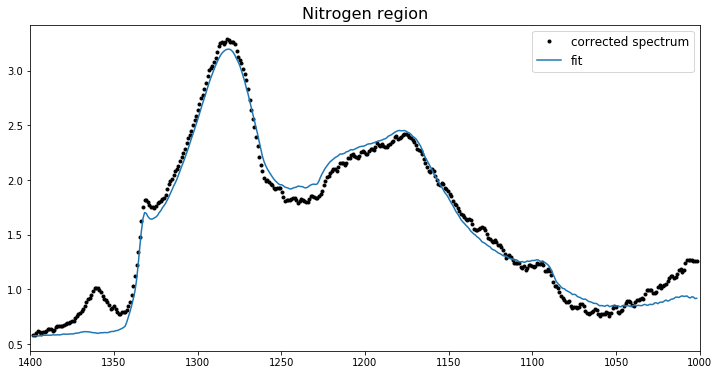

In [86]:
plt.figure()
plt.plot(N_area[:,0], N_area[:,1], 'k.', label='corrected spectrum')
plt.plot(N_wav_new, N_fit, '-', label='fit')
plt.title('Nitrogen region', fontsize=16)
plt.xlim(1000, 1400)
plt.gca().invert_xaxis()
plt.legend(loc='best', fontsize=12)

In [87]:
c, a, x, b, d, N_poly = [], [], [], [], [], []
N_res_idx = 0

for (idx, val), comp in zip(enumerate(N_selection), (c, a, x, b, d, N_poly)):
    if val == 0:
        comp.append(np.nan)
    elif val == 1:
        comp.append(N_res.x[N_res_idx])
        N_res_idx += 1

NC = float(c[0])*25
NA = float(a[0])*16.5
NB = float(b[0])*79.4
NT = NA+NB+NC

print('Nitrogen concentrations:')
print('C: {} ppm'.format(np.round(NC,1)))
print('A: {} ppm'.format(np.round(NA,1)))
print('B: {} ppm'.format(np.round(NB,1)))

Nitrogen concentrations:
C: nan ppm
A: 36.3 ppm
B: 28.7 ppm
